# Sklearn make_scorer: Créer vos propres métriques

URL : https://youtu.be/zPEaC_yvL_k?si=IqtAwnCGGhY8UtNe

Apprendre à utiliser la fonction **make_scrorer de sklearn**.

Cette fonction est utile pour créer **ses propres métriques** dans sklearn et développer des modeles de Machine Learning / Data Science sur la base de ces métriques (**via la Cross Validation et GridSeachCV**).

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVR

Text(0.5, 1.0, 'Données générées')

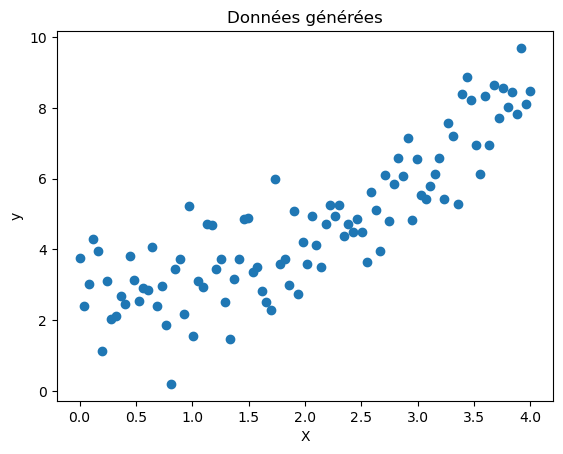

In [5]:
#np.random.seed(0) fixe la graine du générateur de nombres aléatoires
#ce qui permet d'obtenir des résultats reproductibles à chaque exécution du code
np.random.seed(0)

#nombre de points de données à générer  
m = 100

#X = np.linspace(0, 4, m).reshape(m, 1) génère un tableau X contenant 100 points également espacés entre 0 et 4
#et les modèle en une forme colonne (m, 1)
X= np.linspace(0, 4, m).reshape(m, 1)

#calculer les valeurs y en utilisant une relation non linéaire (une fonction polynomiale)
#et y ajouter un bruit aléatoire pour simuler des variations observées dans des données réelles 
y= 2 + X**1.3 + np.random.randn(m, 1)

#tracer les points de données sur un graphique y en fonction de X
#créer un nuage de points à partir des valeurs X et y
plt.scatter(X, y)  

plt.xlabel('X')  #l'axe des x  
plt.ylabel('y')  #l'axe des y  
plt.title('Données générées')  #ajouter un titre

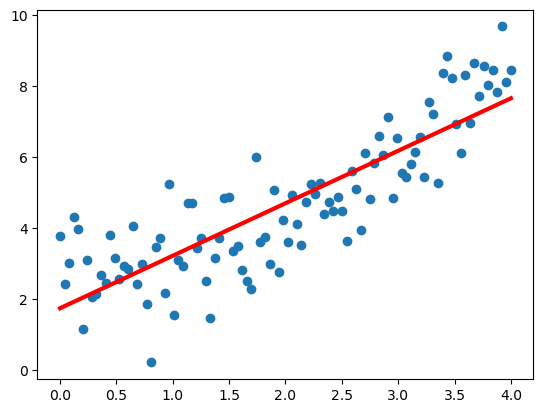

In [6]:
#définir le modèle de régression linéaire
model = LinearRegression()

#entraîner le modèle
model.fit(X, y)

#définir y_pred
y_pred = model.predict(X)

#créer un nuage de points à partir des valeurs X et y
plt.scatter(X, y)  

#tracer le graphique, y_pred en fonstion de X
#définir la couleur de la courbe (c='r') et son épaisseur (lw=3)
plt.plot(X, y_pred, c='r', lw=3)

In [7]:
#calculer les erreurs entre y et y_pred
mean_absolute_error(y, y_pred)

0.8739397321740953

- Le client s'attend à un modèle qui respecte la condition suivante:

toutes les valeurs de prédiction doivent être dans une zone de tolérance de 20% (plus ou moins 20%) par rapport à nos vraies valeurs y.

Pour bien visualiser ce que ça représente, on trace le résultat, ça voudrait dire qu'il faut que les prédictions (y_pred en fonstion de X) soient toujours entre les deux marges vertes.

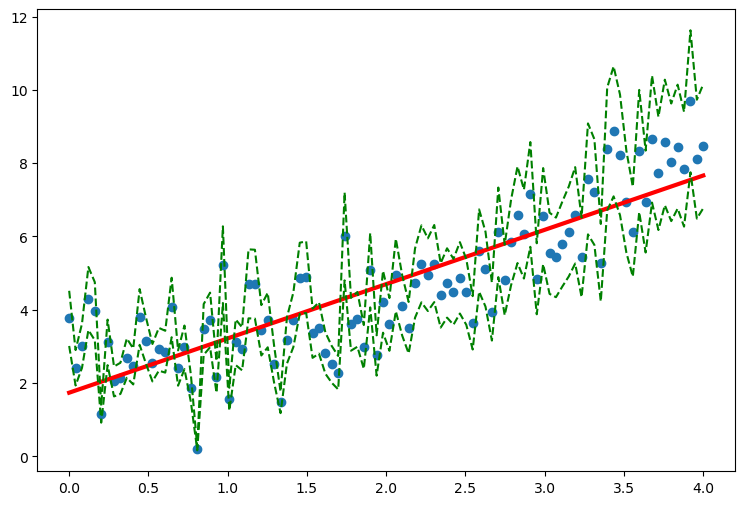

In [9]:
#une figure avec des dimensions personalisées
plt.figure(figsize=(9, 6))

#créer un nuage de points, X en fonction de y
plt.scatter(X, y)  

#tracer le graphique, y_pred en fonstion de X
#définir la couleur de la courbe (c='r') et son épaisseur (lw=3)
plt.plot(X, y_pred, c='r', lw=3)

#tracer le graphique, y+y*0.2 en fonstion de X
#définir la couleur de la courbe (c='g') et son style (ls=--)
plt.plot(X, y+y*0.2, c='g', ls='--')

#tracer le graphique, y-y*0.2 en fonstion de X
#définir la couleur de la courbe (c='g') et son style (ls=--)
plt.plot(X, y-y*0.2, c='g', ls='--')

Pour réussir à développer un modèle, et l'évaluer avec les métriques de notre client, on va devoir suivre les étapes suivantes:

- D'abord il faut se rappeler qu'une métrique dans SKlearn c'est juste une fonction, qu'on peut très bien définir nous même, cette fonction prend deux arguments, y et y_pred (**fonction: f(y, y_pred**), mais une fois qu'on a défini cette fonction la question qu'on va se poser c'est comment est-ce qu'on peut l'utiliser dans une cross validation ou bien dans un algorithme d'optimisation comme GridSearchCV.

- Pour ça, il faut transformer notre fonction en un scorer en utilisant la fonction **make_scorer()**, après on peut l'utiliser dans des algorithmes de cross validation.

In [11]:
def custom_metric(y, y_pred):  
    """  
    Calcule une métrique personnalisée pour évaluer les prédictions.  
    
    Paramètres:  
    y : les valeurs cibles réelles.  
    y_pred : les valeurs prédites.  

    Retourne: le nombre de prédictions qui se situent dans une plage de ±20% de la valeur réelle.  
    """  
    # Calcule le nombre de prédictions dans la plage spécifiée  
    return np.sum((y_pred < y + y * 0.2) & (y_pred > y - y * 0.2))
    
custom_metric(y, y_pred)

63

In [12]:
#parmi les 100 points, il y a 63 points de prédictions dans la plage spécifiée du client

In [13]:
#pour avoir un pourcentage, on divive par y.size
def custom_metric(y, y_pred):  
    return np.sum((y_pred < y + y * 0.2) & (y_pred > y - y * 0.2))/y.size
    
custom_metric(y, y_pred)

0.63

In [14]:
#donc on a 63% des prédictions qui sont OK par rapport à la plage spécifiée du client

- On doit faire passer ça dans la fonction **make_scorer()**, pour l'utiliser dans des algorithmes de cross validation.

-  la fonction make_scorer, de la bibliothèque scikit-learn, permet de transformer une fonction de métrique (comme custom_metric) en un scoreur compatible avec les méthodes d'évaluation de scikit-learn.

Sa formule est: **make_scorer(function, greater_is_better)**

In [16]:
#création d'un scoreur personnalisé en utilisant la fonction custom_metric
#l'argument greater_is_better=True indique que des valeurs plus élevées du score (ici 63%) sont meilleures
#ici, cela signifie qu'on souhaite maximiser le nombre de prédictions dans la plage acceptée (±20%)
#plus on s'approche de 100% meilleur est le modèle
custom_score = make_scorer(custom_metric, greater_is_better=True)

In [17]:
#réaliser une validation croisée sur le modèle de régression linéaire
cross_val_score(LinearRegression(), X, y, cv=3, scoring=custom_score)

#X et y : les données sur lesquelles vous effectuez la validation
#cv=3 : indique que vous voulez utiliser 3 plis (folds) pour la validation croisée
#les données seront divisées en 3 parties où chaque partie sera alternativement utilisée comme ensemble de test
#scoring=custom_score : utilise le scoreur personnalisé défini précédemment

array([0.08823529, 0.42424242, 0.3030303 ])

In [18]:
#les scores obtenus sont assez mauvais

In [19]:
#on va voir comment améliorer ce modèle avec un autre type d'algorithme, et ainsi obtenir un meilleur score
#en utilisant GridSearchCV

In [20]:
#modèle de régression avec SVR (Support Vector Regression) utilisant un noyau RBF  
model = SVR(kernel='rbf', degree=3)

#créer un dictionnaire contenant les valeurs de gamma à tester, pour la recherche des meilleurs hyperparamètres
#np.arange(0.1, 1, 0.05) génère une série de valeurs de gamma allant de 0.1 à 1 avec un pas de 0.05
params = {'gamma': np.arange(0.1, 1, 0.05)}  

#initialisation de GridSearchCV pour trouver les meilleurs paramètres
#model : le modèle à optimiser
#param_grid=params : les paramètres à tester (dans ce cas, seulement gamma)
#cv=3 : utilise 3 plis pour la validation croisée
#scoring=custom_score : utilise votre scoreur personnalisé pour évaluer les performances
grid = GridSearchCV(model, param_grid=params, cv=3, scoring=custom_score)  

#grid.fit(X, y) ajuste le modèle aux données X et y
#en testant toutes les combinaisons de paramètres spécifiées dans la grille
grid.fit(X, y)

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'gamma': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
             scoring=make_scorer(custom_metric, response_method='predict'))

In [21]:
#récupération du meilleur modèle trouvé par GridSearchCV
#extrait le meilleur modèle trouvé par GridSearchCV après l'ajustement sur les données
#ce modèle est optimisé selon les paramètres testés
best_model = grid.best_estimator_

In [22]:
#y_pred = best_model.predict(X) utilise le meilleur modèle pour faire des prédictions sur les données d'entrée X
#cela produit un tableau y_pred contenant les valeurs prédites
y_pred = best_model.predict(X)

#évaluation des prédictions à l'aide de la métrique personnalisée  
custom_metric(y, y_pred)

# custom_metric(y, y_pred) calcule le score en utilisant la fonction custom_metric définie précédemment
#et compare les valeurs prédites (y_pred) avec les valeurs réelles (y)

26.62

In [23]:
'''
Dans la vidéo, on obtient un score de 0.65 (càd une performance de 65%)
Ici on obtient 26.62 (??!)
'''

'\nDans la vidéo, on obtient un score de 0.65 (càd une performance de 65%)\nIci on obtient 26.62 (??!)\n'

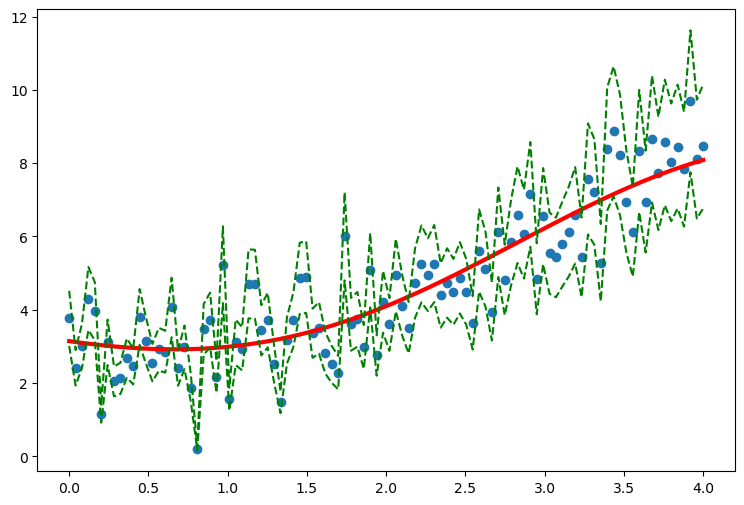

In [24]:
#une figure avec des dimensions personalisées
plt.figure(figsize=(9, 6))

#créer un nuage de points, X en fonction de y
plt.scatter(X, y)  

#tracer le graphique, y_pred en fonstion de X
#définir la couleur de la courbe (c='r') et son épaisseur (lw=3)
plt.plot(X, y_pred, c='r', lw=3)

#tracer le graphique, y+y*0.2 en fonstion de X
#définir la couleur de la courbe (c='g') et son style (ls=--)
plt.plot(X, y+y*0.2, c='g', ls='--')

#tracer le graphique, y-y*0.2 en fonstion de X
#définir la couleur de la courbe (c='g') et son style (ls=--)
plt.plot(X, y-y*0.2, c='g', ls='--')